#**Домашнее задание по NLP** 

Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [ ]:
import pandas as pd
import json
import bz2

In [ ]:
with bz2.open('banki_responses.json.bz2', 'rt', encoding='utf-8') as f:
  json_df = pd.read_json(f, lines=True)

In [ ]:
json_df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Воронеж,True,Ипотека на 5+,0,лицензия № 1623,e.novikova,ВТБ 24,2015-06-08 11:06:56,Здравствуйте! Хотелось бы выразить благодарно...,5.0
1,г. Казань,True,ЗВОНКИ СОСЕДЯМ,0,лицензия № 2289,KZN\Vorontsova_NA,Русский Стандарт,2015-06-06 18:17:52,Уважаемые представители департамента по работе...,2.0
2,г. Санкт-Петербург,True,Ложная информация!!!!,0,лицензия № 2307,Evgenia15,Союз,2015-06-07 19:08:33,Здравствуйте. Столкнулась с такой ситуацией. в...,2.0
3,г. Москва,True,Банкомат не зачислил деньги на счет,1,лицензия № 2557,dolgov.work,Ситибанк,2015-06-07 19:22:00,1 июня 2015 в Москве в отделении по адресу Смо...,1.0
4,г. Волгоград,True,Невозможно закрыть карту 2(два)!!!,0,лицензия № 3354,copLine,Ренессанс Кредит,2015-06-08 14:54:55,История очень долгая! Пришел я в банк (это раз...,1.0


In [ ]:
df_1or5 = json_df[(json_df['rating_grade'] == 1)|(json_df['rating_grade'] == 5)]

In [ ]:
df_1or5['rating_grade'].unique()

array([5., 1.])

сократим датафрейм до 10000 строк

In [ ]:
df_1or5 = df_1or5.iloc[:10000]

#Часть 1. Обучение модели word2vec

**1)Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.**

In [ ]:
from nltk.tokenize import word_tokenize
from string import punctuation

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re 

In [ ]:
! pip install pymorphy2
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
m = pymorphy2.MorphAnalyzer()

In [ ]:
# функция возвращает только слова
def words_only(text):
    if re.findall("[А-Яа-я]+",text):
     return text

In [ ]:
def pre_process(text): # функция для преобразования,очистки текста и лемматизации
  doc_out = []
  for token in word_tokenize(text):
    if token not in stopwords.words('russian') and token not in punctuation:
      word = words_only(m.parse(token)[0].normal_form)
      if word:
          doc_out.append(word)
  return doc_out

In [ ]:
from tqdm import tqdm

In [ ]:
sentences = []  

print("Parsing sentences from training set...")
for text in tqdm(df_1or5['text']):
    sentences.append(pre_process(text))

Parsing sentences from training set...


100%|██████████| 10000/10000 [11:40<00:00, 14.27it/s]


**2) Обучите по коллекции предложений word2vec**

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models import word2vec

In [ ]:
model = word2vec.Word2Vec(sentences, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3)

Смотрим, сколько в модели слов

In [ ]:
print(len(model.wv.key_to_index))

6437


**3) Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:**

* тест на определение ближайших слов

In [ ]:
model.wv.similarity('сумма', 'приехать')

0.049841873

In [ ]:
model.wv.similarity('банк', 'сбербанк')

0.3477265

In [ ]:
model.wv.similarity('кредитование', 'ипотека')

0.6288083

* тест на аналогии (мужчина – король : женщина – королева)

In [ ]:
model.wv.most_similar(positive=['благодарность'] , topn=5)

[('выразить', 0.9629625082015991),
 ('признательность', 0.9465771317481995),
 ('поблагодарить', 0.9427579045295715),
 ('выражать', 0.93925940990448),
 ('профессионализм', 0.8826966285705566)]

In [ ]:
model.wv.most_similar(positive=['банк'] , topn=5)

[('альфа-банк', 0.3820893466472626),
 ('ваш', 0.373166561126709),
 ('ранее', 0.36782029271125793),
 ('сбербанк', 0.3477264940738678),
 ('подобный', 0.31976962089538574)]

In [ ]:
model.wv.most_similar(positive=['специалист'] , topn=5)

[('менеджер', 0.7627145648002625),
 ('сотрудница', 0.7194541096687317),
 ('девушка', 0.6715402603149414),
 ('выслушать', 0.6597384214401245),
 ('сотрудник', 0.6356064677238464)]

* тест на определение лишнего слова

In [ ]:
model.wv.doesnt_match(['сотрудник','менеджер','кредит'])

'кредит'

In [ ]:
model.wv.doesnt_match(['организация','оценка','сторонний'])

'оценка'

**4) Постройте несколько визуализаций:**

* TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter

In [ ]:
words = []
for i in sentences:
  words.extend(i)

In [ ]:
top100_words= [word for word, word_count in Counter(words).most_common(100)]

In [ ]:
# создадим матрицу расстояний между словами
distance_matrix = np.zeros((len(top100_words), len(top100_words)))
for i in range(len(top100_words)):
    for j in range(len(top100_words)):
        distance_matrix[i][j] = model.wv.similarity(top100_words[i], top100_words[j])

In [ ]:
# применим метод TSNE для снижения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne.fit_transform(distance_matrix)

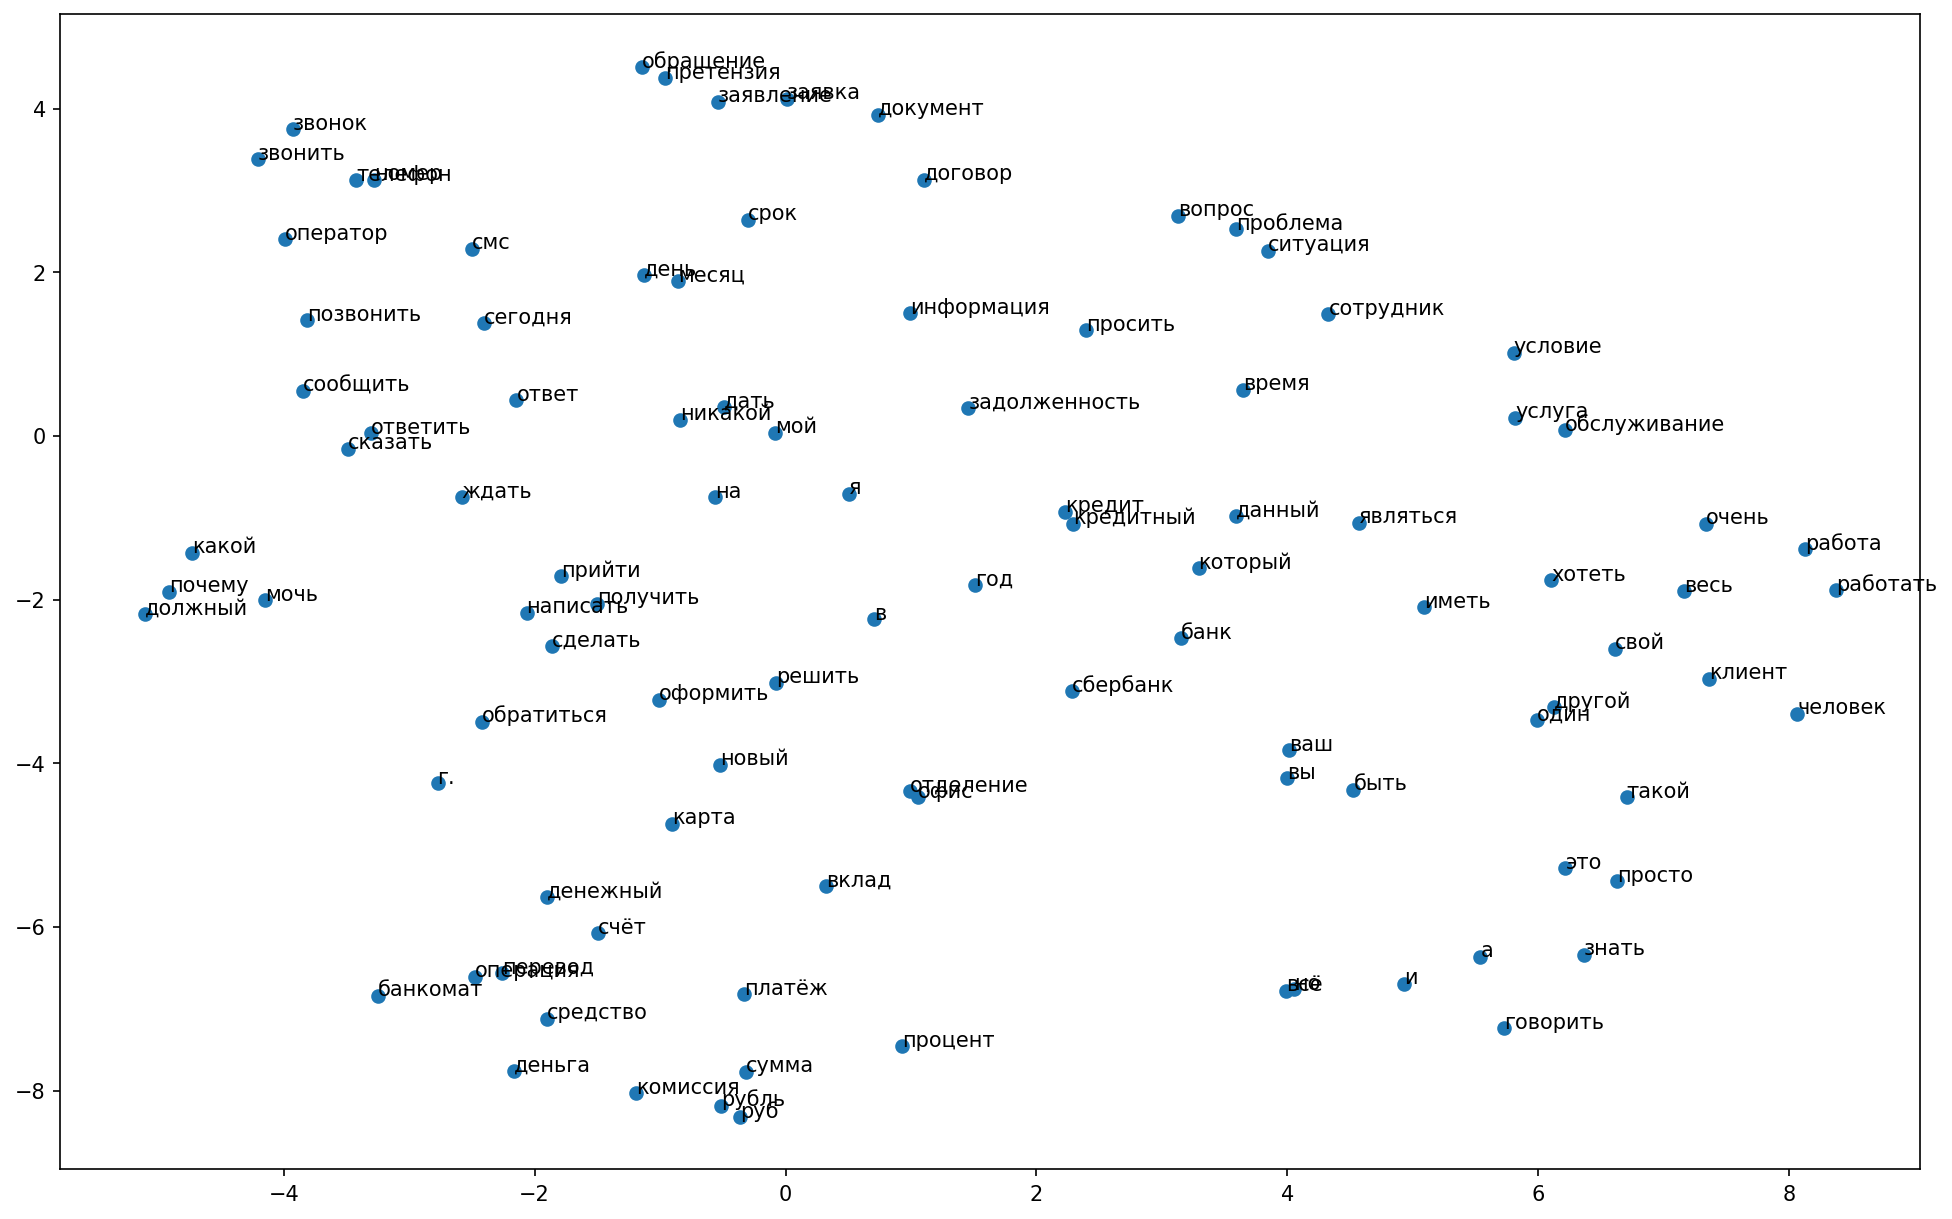

In [ ]:
# визуализируем полученные координаты
df = pd.DataFrame({'x': tsne_embedding[:, 0], 'y': tsne_embedding[:, 1], 'word': top100_words})
plt.figure(figsize=(16, 10), dpi=150)
plt.scatter(df['x'], df['y'])
for i, row in df.iterrows():
    plt.annotate(row['word'], xy=(row['x'], row['y']), fontsize=10)
plt.show()

In [ ]:
# применим метод k-means для кластеризации
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(distance_matrix)
df['cluster'] = kmeans.labels_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


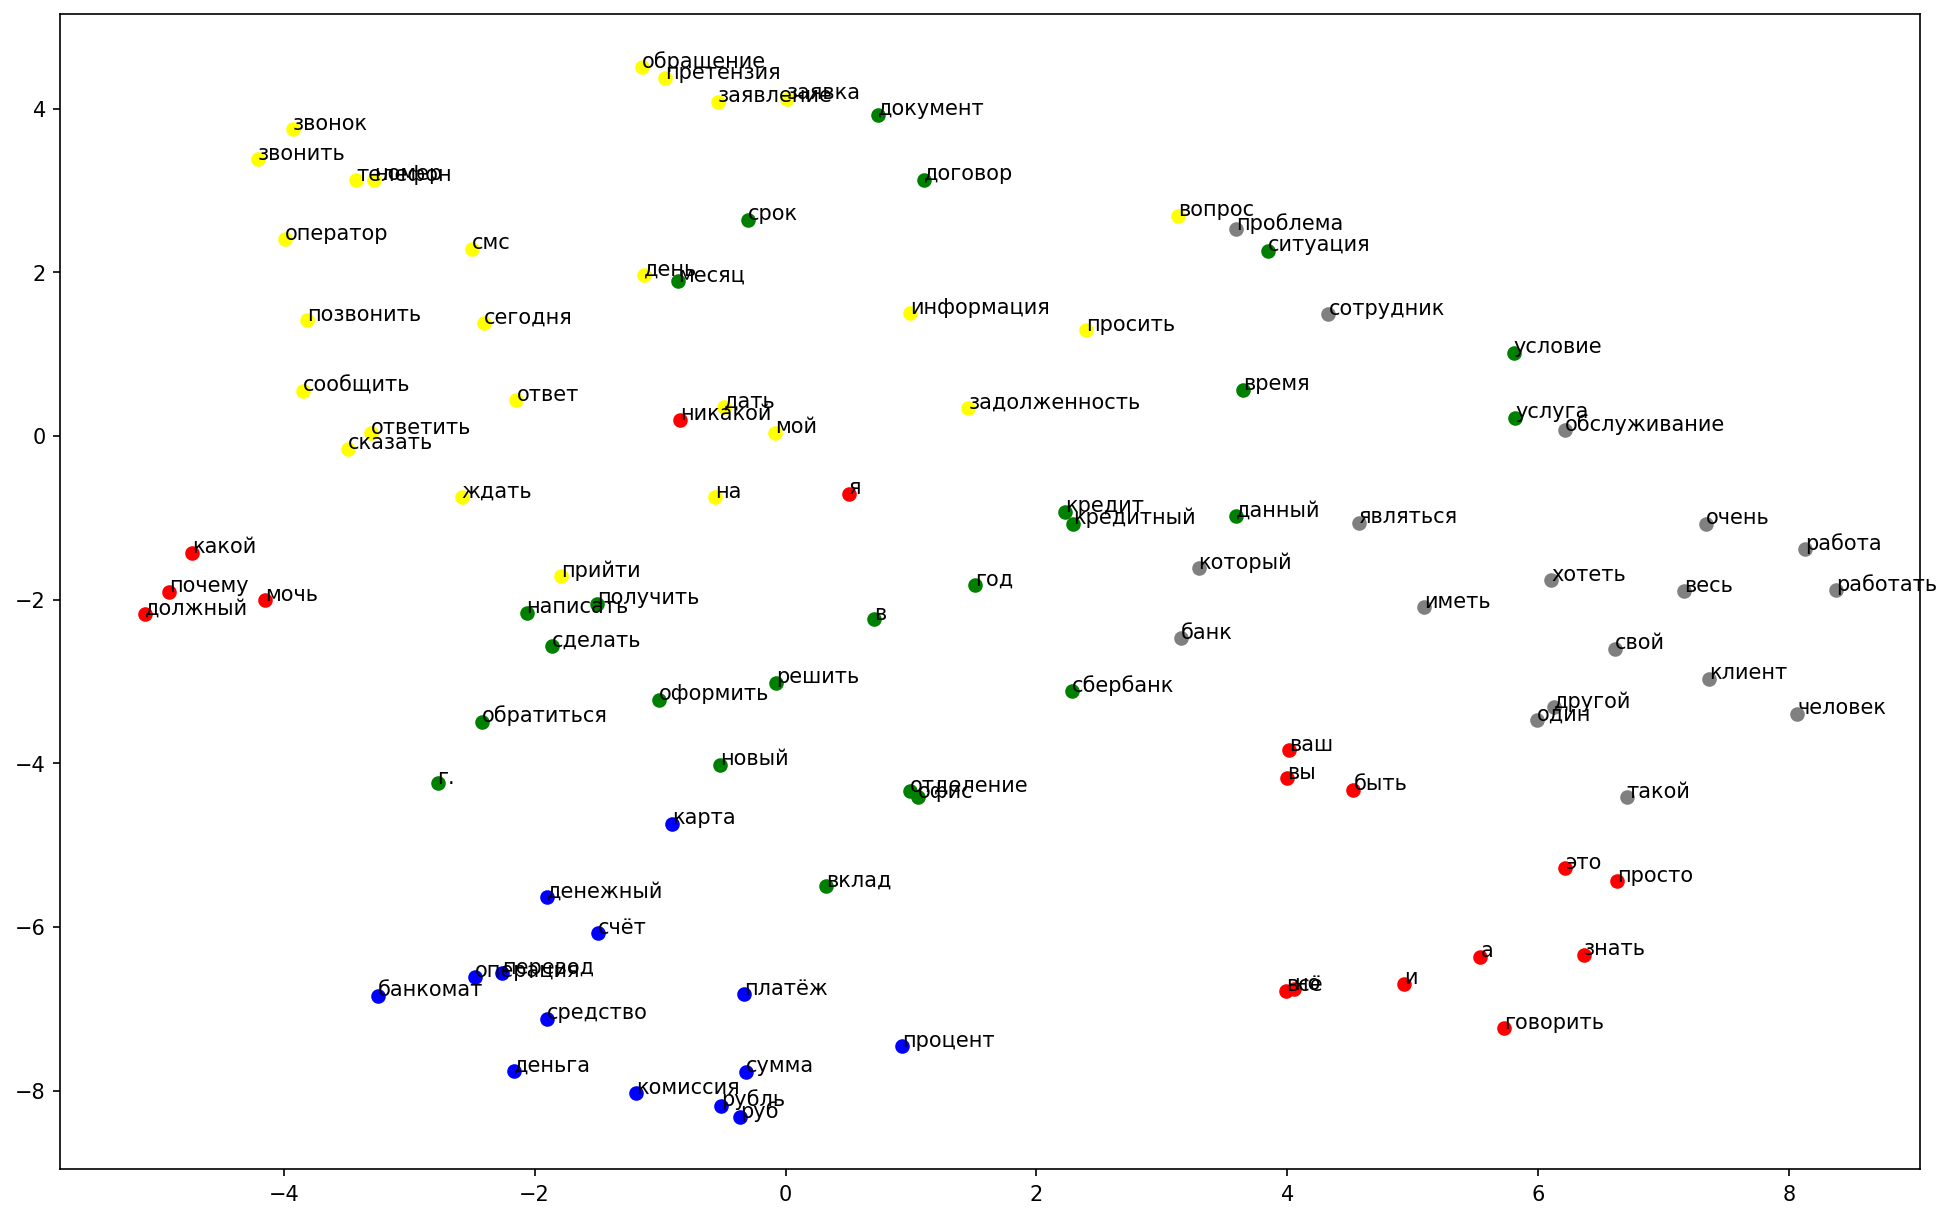

In [ ]:
# визуализируем кластеры
plt.figure(figsize=(16, 10), dpi=150)
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow' , 4: 'gray'}
for i, row in df.iterrows():
    plt.scatter(row['x'], row['y'], color=colors[row['cluster']])
    plt.annotate(row['word'], xy=(row['x'], row['y']), fontsize=10)
plt.show()

* задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально:
берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [ ]:
bank_names = ['сбербанк', 'альфа-банк', 'втб', 'промсвязьбанк', 'мкб', 'росбанк','псб','метробанк','ткс']

In [ ]:
# определим вектора
vector_1 = model.wv['хорошо'] - model.wv['плохо']
vector_2 = model.wv['быстро'] - model.wv['медленно']

In [ ]:
# создадим матрицу координат для названий банков
bank_coordinates = np.zeros((len(bank_names), 2))
for i in range(len(bank_names)):
    bank_vector = model.wv[bank_names[i]]
    # вычислим координаты по первой оси
    bank_coordinates[i, 0] = np.dot(bank_vector, vector_1)
    # вычислим координаты по второй оси
    bank_coordinates[i, 1] = np.dot(bank_vector, vector_2)

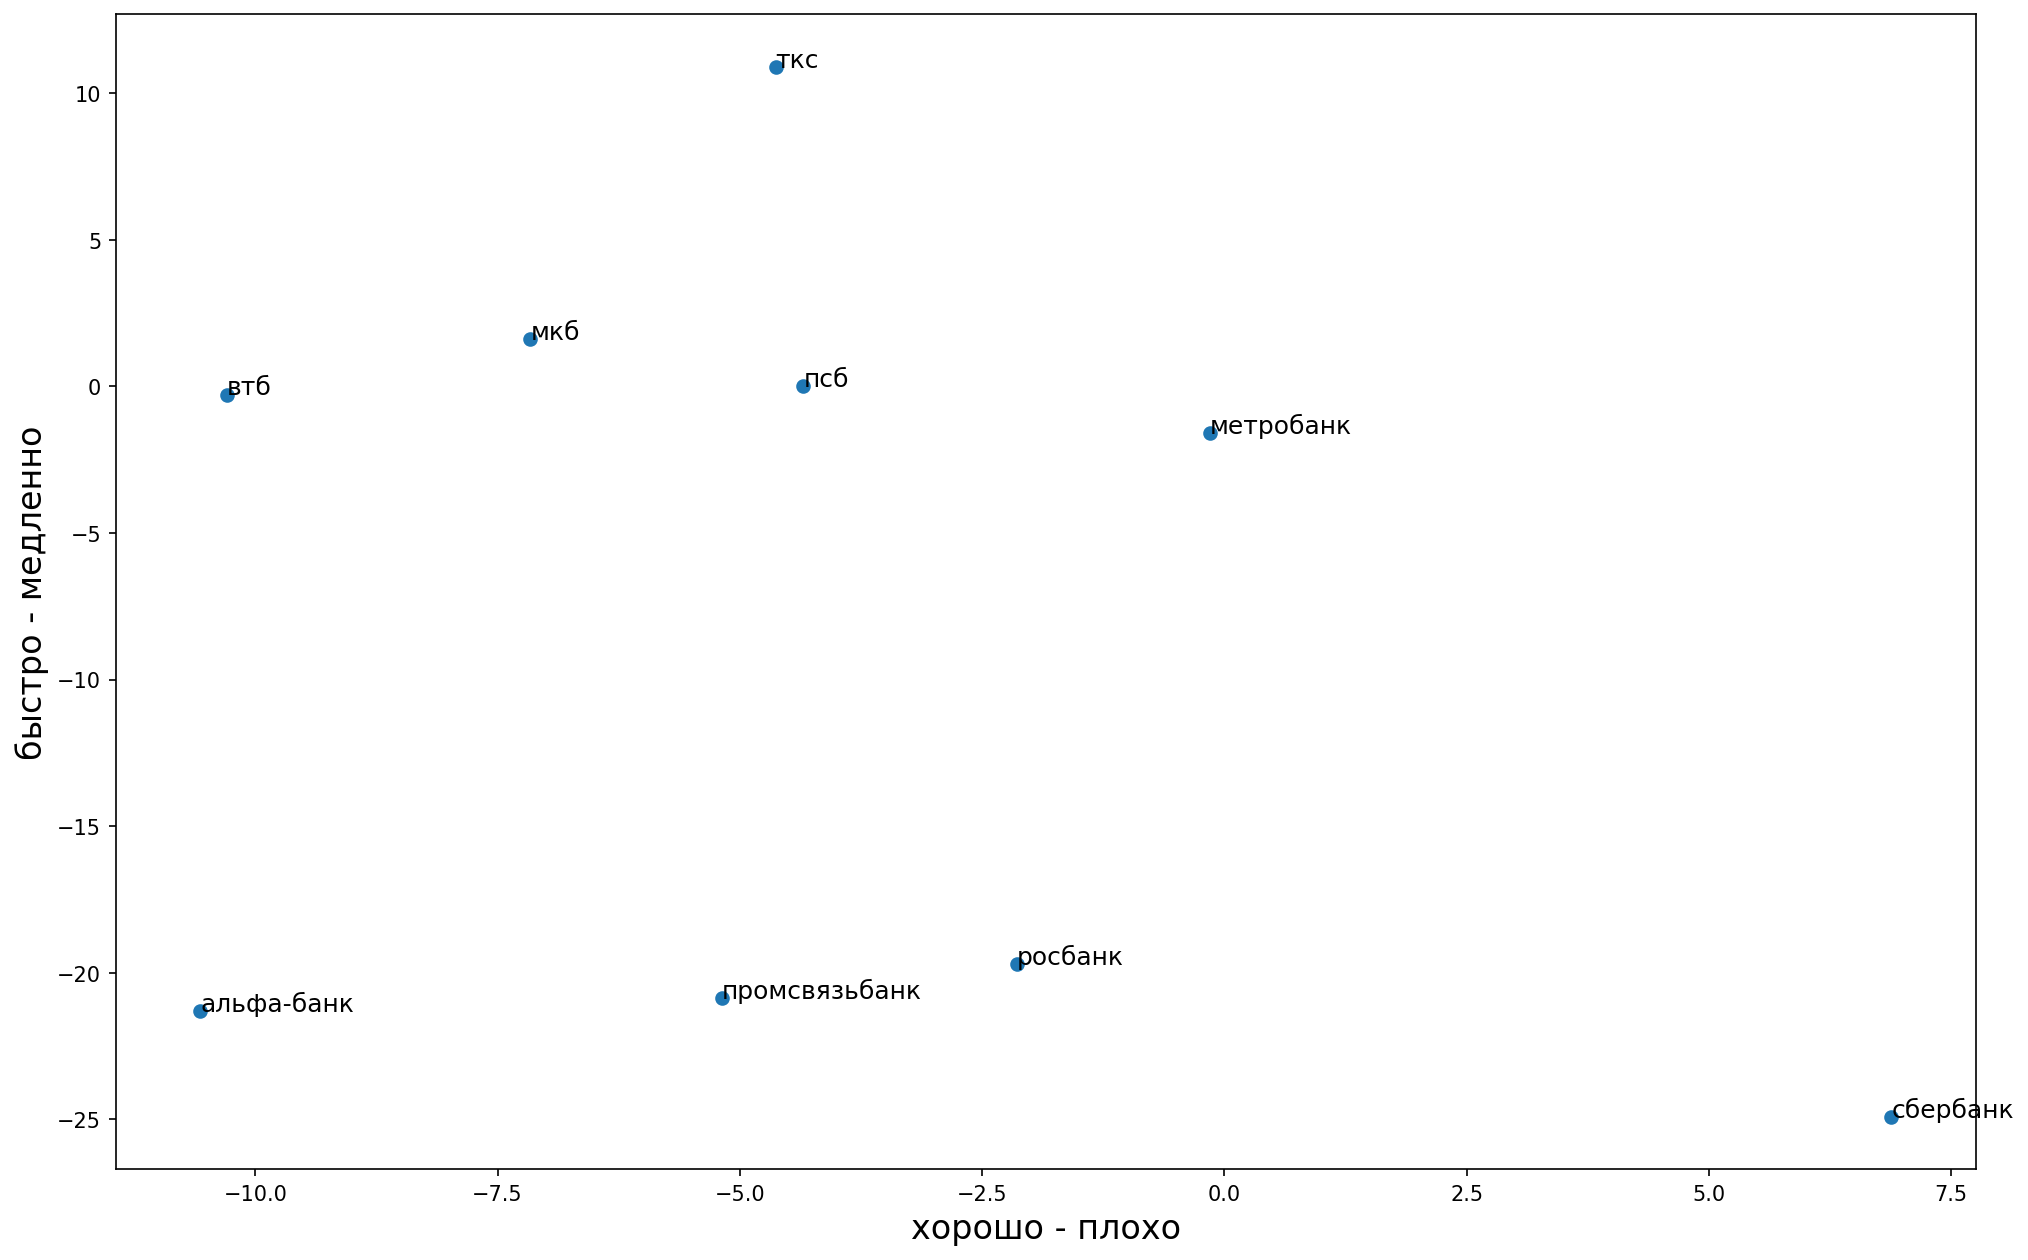

In [ ]:
# визуализируем полученные координаты
df = pd.DataFrame({'x': bank_coordinates[:, 0], 'y': bank_coordinates[:, 1], 'bank_name': bank_names})
plt.figure(figsize=(16, 10), dpi=150)
plt.scatter(df['x'], df['y'])
plt.xlabel('хорошо - плохо', fontsize=16)
plt.ylabel('быстро - медленно', fontsize=16)
for i, row in df.iterrows():
    plt.annotate(row['bank_name'], xy=(row['x'], row['y']), fontsize=12)
plt.show()